In [1]:
import sys
sys.path.append("/home/imglab/Yi_Zhu/Smart_Project_v11/")
import os
from digital_network import *
from digital_unit import *
from torch.utils.data import Dataset, DataLoader, random_split
from new_shapes_dataset import TwoPaddedRotationShapesDataset
import matplotlib.pyplot as plt
import pickle
from model_retrieve_utils import *
from utils import *

/home/imglab/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# models parameters

# hyperparameters for training
lr = 0.001
max_epochs = 300

# hyperparameters for training and testing set
num_training_set = 50000
num_testing_set = 10000
shape_size = 0

# hyperparameters for dataset
dimension = 200

# hyperparameters for cnn layer
in_c = 1
out_c = 4      # kernels 
fc_in = out_c

In [3]:
# define dataset and data loader
train_dataset = TwoPaddedRotationShapesDataset(dimension, shape_size=shape_size, length=num_training_set)
train_loader = DataLoader(train_dataset, batch_size=20, num_workers=6, shuffle=False)

test_dataset = TwoPaddedRotationShapesDataset(dimension, shape_size=shape_size, length=num_testing_set)
test_loader = DataLoader(test_dataset, batch_size=2, num_workers=6, shuffle=False)

In [4]:
# saving configurations
server_dir = "/home/imglab/Yi_Zhu/Smart_Project_v11/"
sub_dir = "results/"
dateinfo = "Mar_11_2024_15_20_38/"

model_folder = server_dir + sub_dir + dateinfo +'saved_models/'
curve_folder = server_dir + sub_dir + dateinfo +'saved_training_curves/'

model_file_name = "complex_valued_digital_cnn_4kernel_ep600_lrp0005_Imginverse50x50.pt"
curve_file_name = "complex_valued_digital_cnn_4kernel_ep600_lrp0005_Imginverse50x50.pickle"

MODEL_PATH = model_folder + model_file_name
CURVE_PATH = curve_folder + curve_file_name

In [5]:
model = DigitalCNN(in_c, out_c, fc_in)
model.load_state_dict(torch.load(f=MODEL_PATH))

<All keys matched successfully>

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

DigitalCNN(
  (conv_block_1): ConvBlock(
    (layers): Sequential(
      (0): ComplexConv2d()
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4, out_features=2, bias=True)
  )
)

### Analysis Model

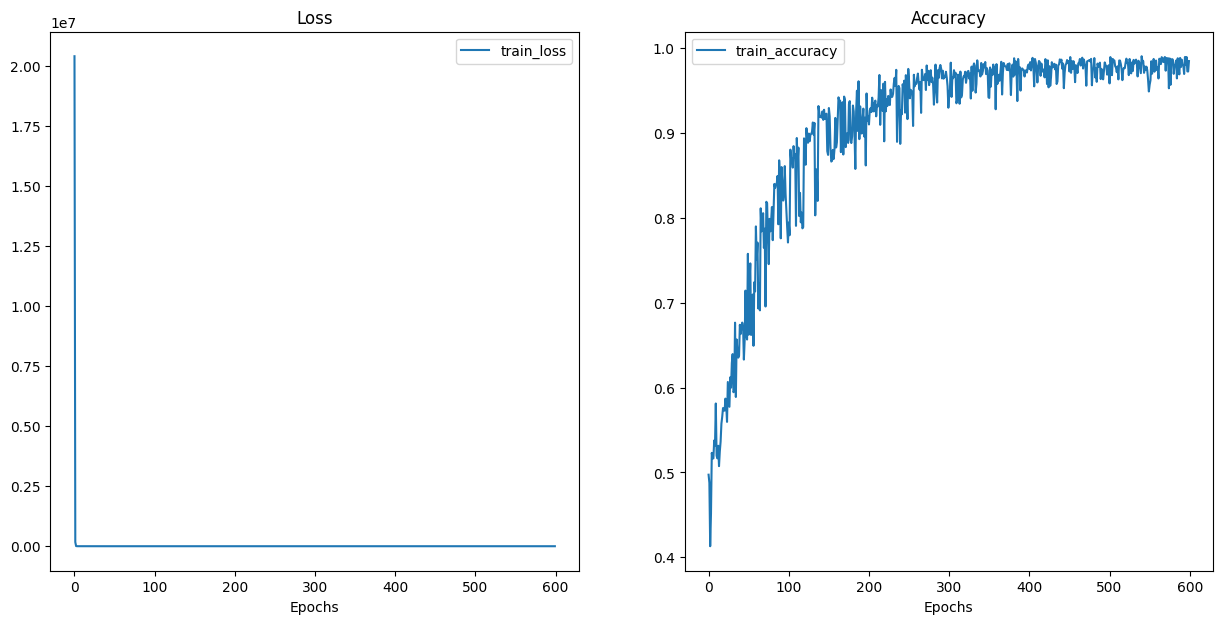

In [7]:
# training curve
with open(CURVE_PATH, 'rb') as handle:
    training_curve = pickle.load(handle)

plot_loss_curves(training_curve)

In [8]:
kernels = model.conv_block_1.layers[0].complex_kernel
kernels.shape

torch.Size([4, 1, 5, 5])

In [9]:
complex_kernels = kernels.squeeze()

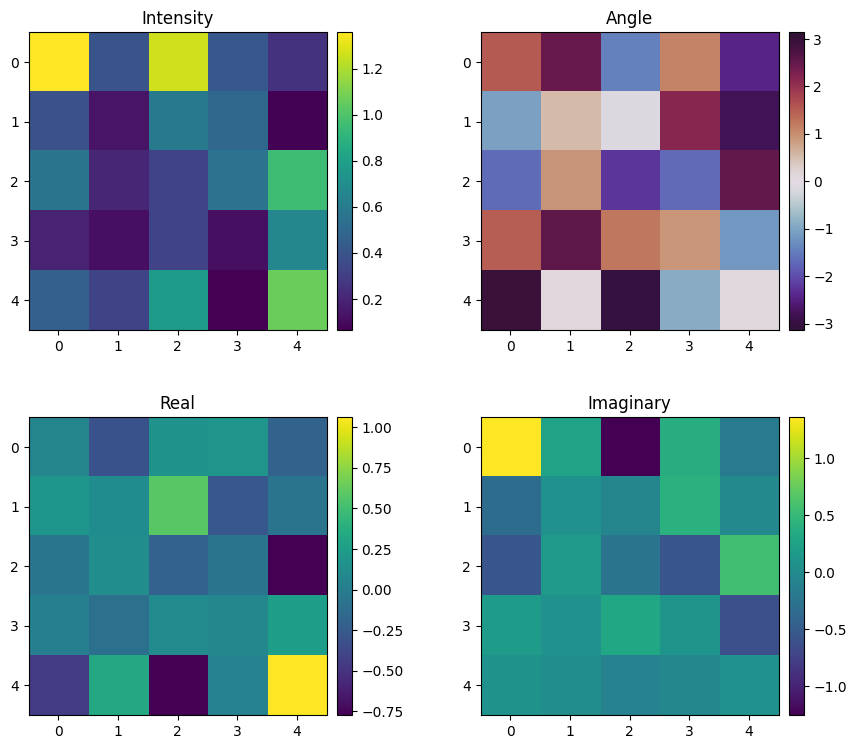

In [10]:
plot_complex_image(complex_kernels[3].cpu().detach().numpy())

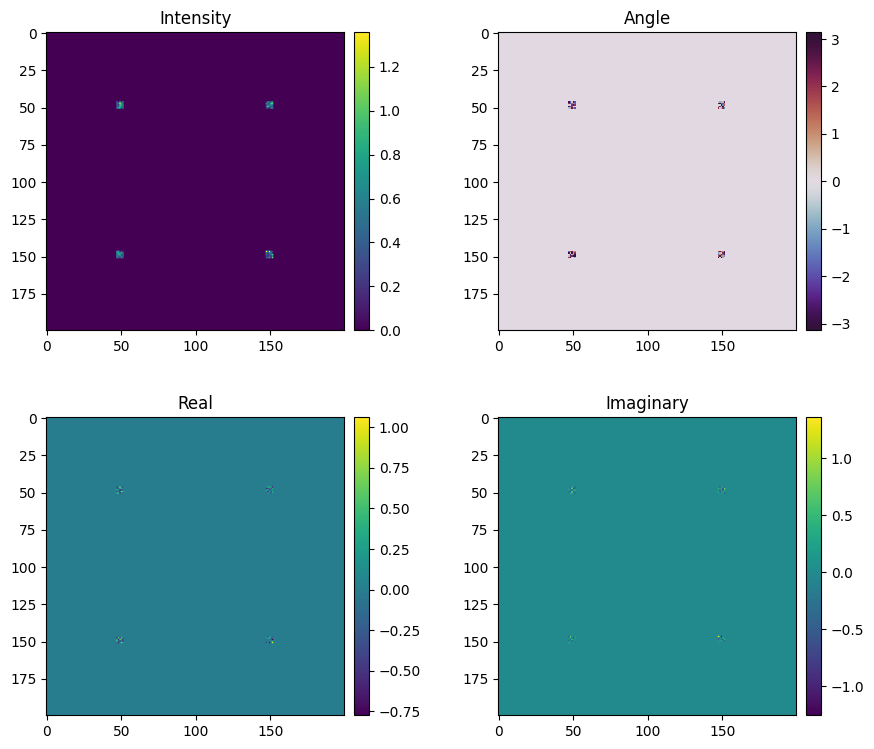

In [12]:
# construct psf label
kernels_padded = padding(complex_kernels, 100)
psf_label_nopad = tile_kernels(kernels_padded.squeeze(), 2, 2).unsqueeze(0)
psf_label = padding(psf_label_nopad, 200)

plot_complex_image(psf_label[0].cpu().detach().numpy())

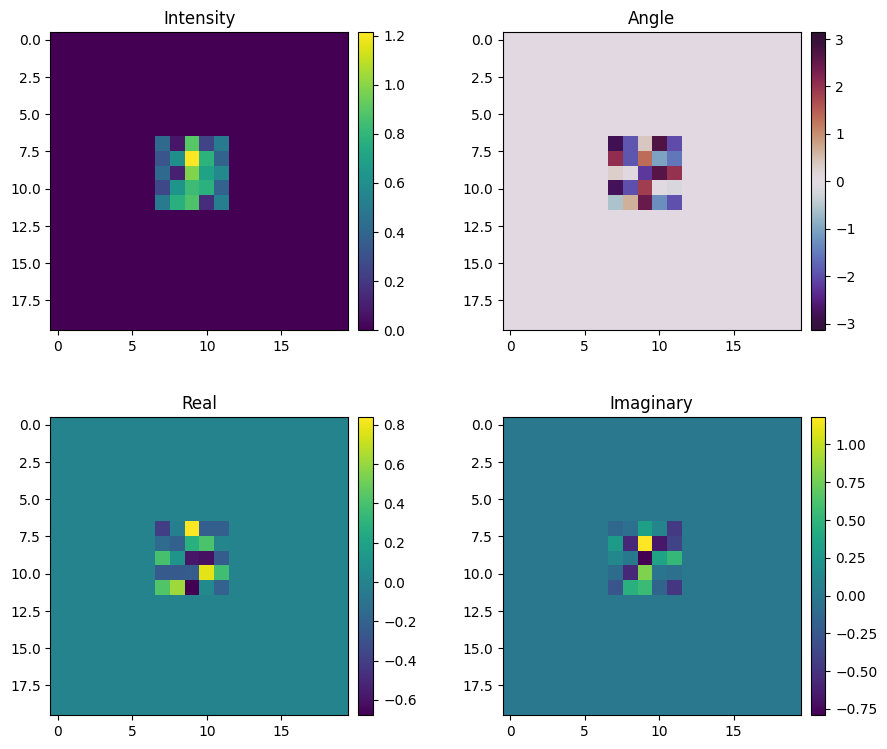

In [14]:
plot_complex_image(psf_label[0][40:60,40:60].cpu().detach().numpy())

### get convolved image

In [15]:

dimension = 200

# hyperparameters for training and testing set
num_training_set = 50000
num_testing_set = 10000
shape_size = 10
canvas_color = 5
fill = 10

# define dataset and data loader
train_dataset = TwoPaddedRotationShapesDataset(dimension, shape_size=shape_size, length=num_training_set, canvas_color=canvas_color, fill=fill)
train_loader = DataLoader(train_dataset, batch_size=20, num_workers=6, shuffle=False)

test_dataset = TwoPaddedRotationShapesDataset(dimension, shape_size=shape_size, length=num_testing_set, canvas_color=canvas_color, fill=fill)
test_loader = DataLoader(test_dataset, batch_size=2, num_workers=6, shuffle=False)

In [16]:
X_train_dummy, y_train_dummy = create_dummy_sample(train_loader, 10)
X_train_dummy.shape, y_train_dummy.shape

(torch.Size([10, 200, 200]), torch.Size([10, 2]))

In [17]:
X_ = X_train_dummy.to(device)

output_field = model.conv_block_1.layers[0](X_.unsqueeze(1))

In [18]:
output_field.shape

torch.Size([10, 4, 200, 200])

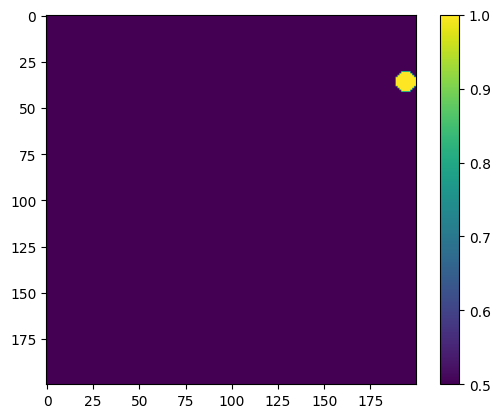

In [19]:
# original image
plt.imshow(X_train_dummy[1])
plt.colorbar()

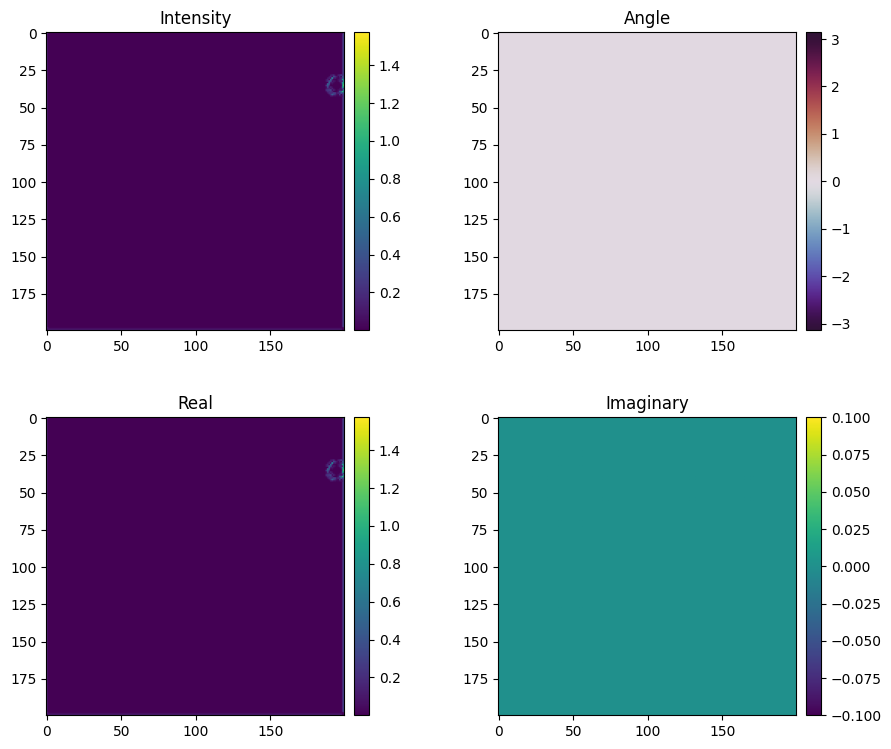

In [20]:
plot_complex_image(output_field[1][0].cpu().detach().numpy())

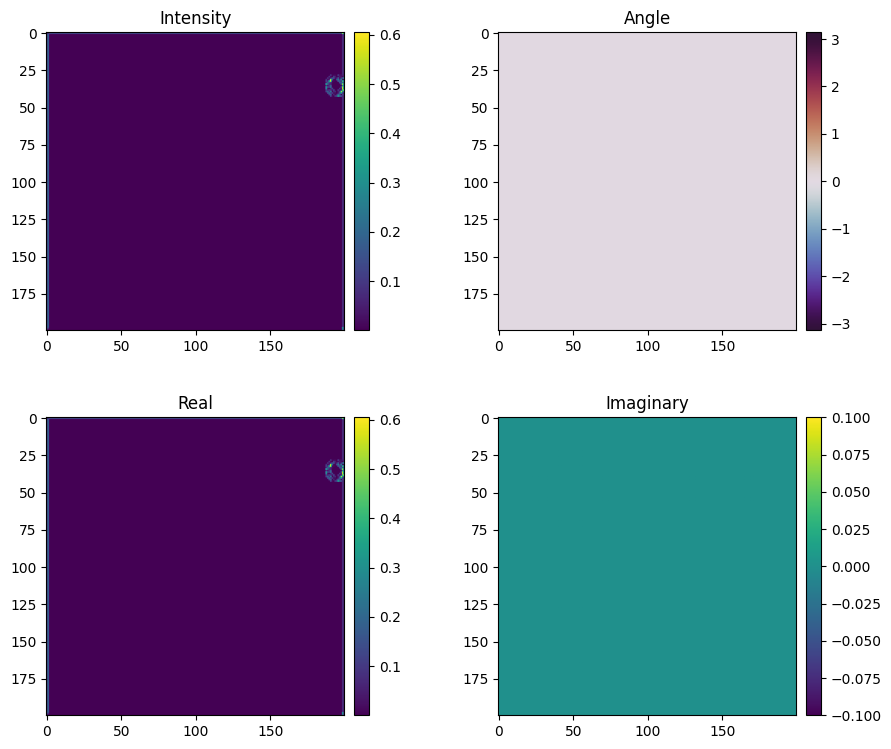

In [21]:
plot_complex_image(output_field[1][1].cpu().detach().numpy())

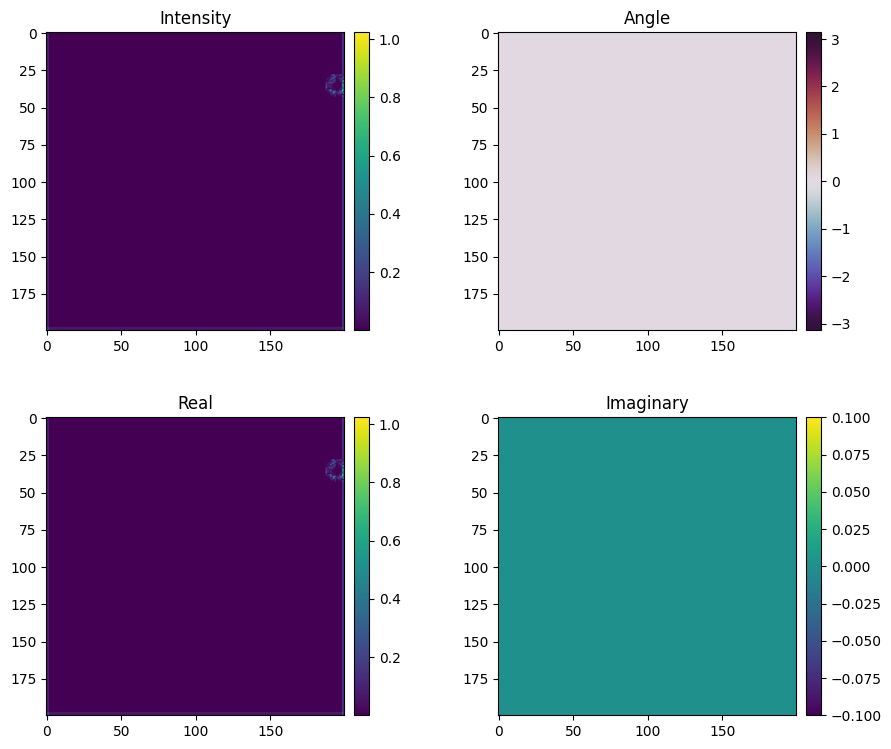

In [22]:
plot_complex_image(output_field[1][2].cpu().detach().numpy())

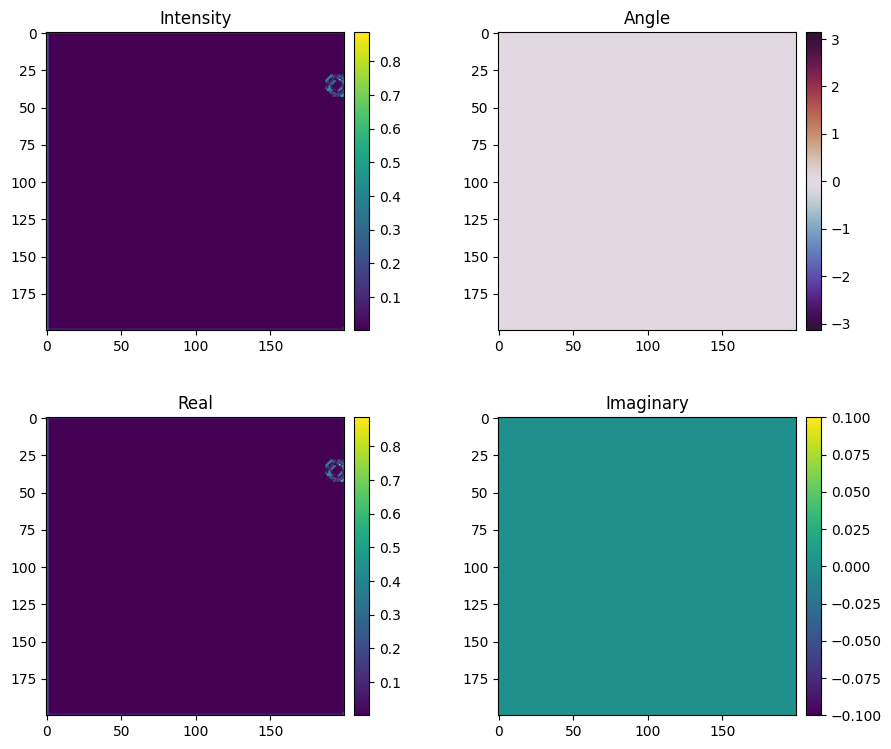

In [23]:
plot_complex_image(output_field[1][3].cpu().detach().numpy())